In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df_res = pd.read_csv("sim_results/rdd_result_noise.csv")

## Coefficients

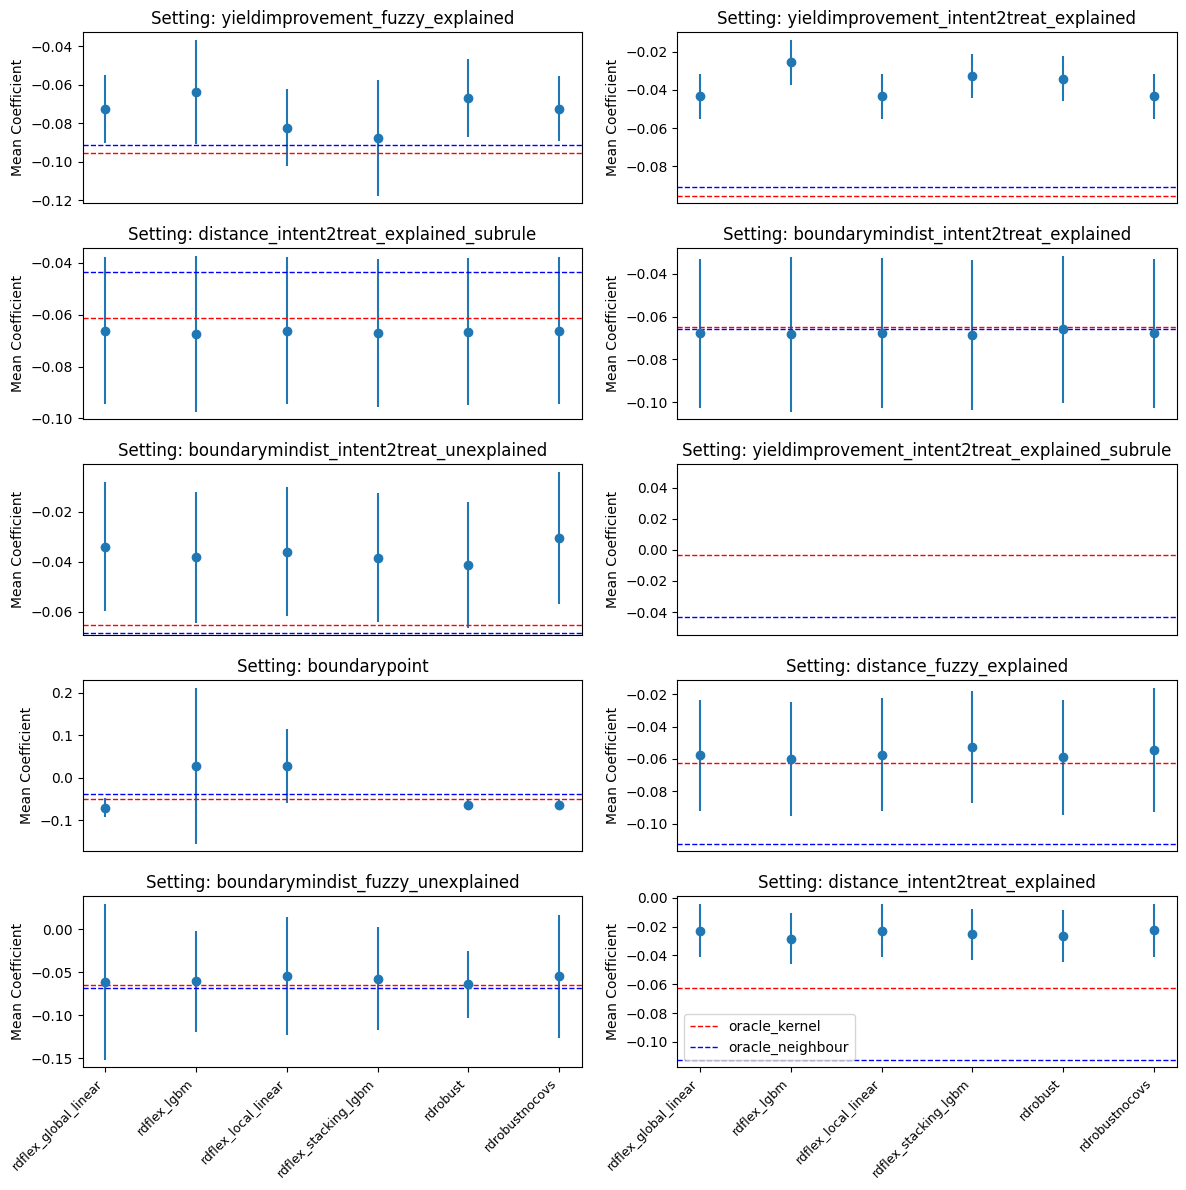

In [ ]:
methods = [
    'rdflex_local_linear', 'rdflex_lgbm', 'rdflex_stacking_lgbm',
    'rdrobustnocovs', 'rdflex_global_linear', 'rdrobust'
]

grouped = df_res.groupby('setting')
unique_settings = df_res['setting'].unique()
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
axes = axes.flatten()

plots_per_row = 2
total_rows = 5

for idx, (ax, s) in enumerate(zip(axes, unique_settings)):
    # Filter data for current setting
    sdf = grouped.get_group(s)
    sdf_mean = sdf.groupby('method')[['coef_robust', 'ci_0025_robust', 'ci_0975_robust']].mean().reset_index()
    sdf_mean = sdf_mean[sdf_mean['method'].isin(methods)]
    
    # Error bars for the methods
    ax.errorbar(
        sdf_mean['method'], sdf_mean['coef_robust'],
        yerr=[
            sdf_mean['coef_robust'] - sdf_mean['ci_0025_robust'],
            sdf_mean['ci_0975_robust'] - sdf_mean['coef_robust']
        ],
        fmt='o'
    )
    
    # Add dashed lines
    oracle_kernel_mean = df_res.loc[(df_res['setting'] == s) & (df_res['method'] == "oracle_kernel"), "coef_conventional"].mean()
    oracle_neighbour_mean = df_res.loc[(df_res['setting'] == s) & (df_res['method'] == "oracle_neighbour"), "coef_conventional"].mean()
    
    ax.axhline(y=oracle_kernel_mean, color='red', linestyle='--', linewidth=1, label='oracle_kernel')
    ax.axhline(y=oracle_neighbour_mean, color='blue', linestyle='--', linewidth=1, label='oracle_neighbour')
    
    ax.set_title(f"Setting: {s}")
    ax.set_ylabel("Mean Coefficient")
    
    # Only add x-ticks and labels to the last row of subplots
    if idx >= (total_rows - 1) * plots_per_row:
        ax.set_xticks(range(len(sdf_mean['method'])))
        ax.set_xticklabels(sdf_mean['method'], rotation=45, ha='right', fontsize=9)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

plt.legend()
plt.tight_layout()
plt.show()

## Oracle

In [54]:
oracle_methods = df_res[df_res['method'].isin(['oracle_kernel', 'oracle_neighbour'])]

descriptive_stats = oracle_methods.groupby(['setting', "method"]).describe()

descriptive_stats = descriptive_stats["coef_conventional"]

In [74]:
descriptive_stats

count  \
setting                                         method                    
boundarymindist_fuzzy_unexplained               oracle_kernel     100.0   
                                                oracle_neighbour  100.0   
boundarymindist_intent2treat_explained          oracle_kernel     100.0   
                                                oracle_neighbour  100.0   
boundarymindist_intent2treat_unexplained        oracle_kernel     100.0   
                                                oracle_neighbour  100.0   
boundarypoint                                   oracle_kernel     100.0   
                                                oracle_neighbour   87.0   
distance_fuzzy_explained                        oracle_kernel     100.0   
                                                oracle_neighbour  100.0   
distance_intent2treat_explained                 oracle_kernel     100.0   
                                                oracle_neighbour  100.0   
distance_intent2treat_explained_subrule         oracle_kernel     100.0   
                                                oracle_neighbour  100.0   
yieldimprovement_fuzzy_explained                oracle_kernel     100.0   
                                                oracle_neighbour  100.0   
yieldimprovement_intent2treat_explained         oracle_kernel     100.0   
                                                oracle_neighbour  100.0   
yieldimprovement_intent2treat_explained_subrule oracle_kernel     100.0   
                                                oracle_neighbour  100.0   

                                                                      mean  \
setting                                         method                       
boundarymindist_fuzzy_unexplained               oracle_kernel    -0.065440   
                                                oracle_neighbour -0.068410   
boundarymindist_intent2treat_explained          oracle_kernel    -0.064954   
                                                oracle_neighbour -0.065696   
boundarymindist_intent2treat_unexplained        oracle_kernel    -0.065440   
                                                oracle_neighbour -0.068410   
boundarypoint                                   oracle_kernel    -0.049182   
                                                oracle_neighbour -0.037470   
distance_fuzzy_explained                        oracle_kernel    -0.062758   
                                                oracle_neighbour -0.112253   
distance_intent2treat_explained                 oracle_kernel    -0.062758   
                                                oracle_neighbour -0.112253   
distance_intent2treat_explained_subrule         oracle_kernel    -0.061390   
                                                oracle_neighbour -0.043351   
yieldimprovement_fuzzy_explained                oracle_kernel    -0.095381   
                                                oracle_neighbour -0.090955   
yieldimprovement_intent2treat_explained         oracle_kernel    -0.095381   
                                                oracle_neighbour -0.090955   
yieldimprovement_intent2treat_explained_subrule oracle_kernel    -0.003371   
                                                oracle_neighbour -0.043513   

                                                                       std  \
setting                                         method                       
boundarymindist_fuzzy_unexplained               oracle_kernel     0.005201   
                                                oracle_neighbour  0.021907   
boundarymindist_intent2treat_explained          oracle_kernel     0.005194   
                                                oracle_neighbour  0.023957   
boundarymindist_intent2treat_unexplained        oracle_kernel     0.005201   
                                                oracle_neighbour  0.021907   
boundarypoint                                   oracle_kernel     0.005008

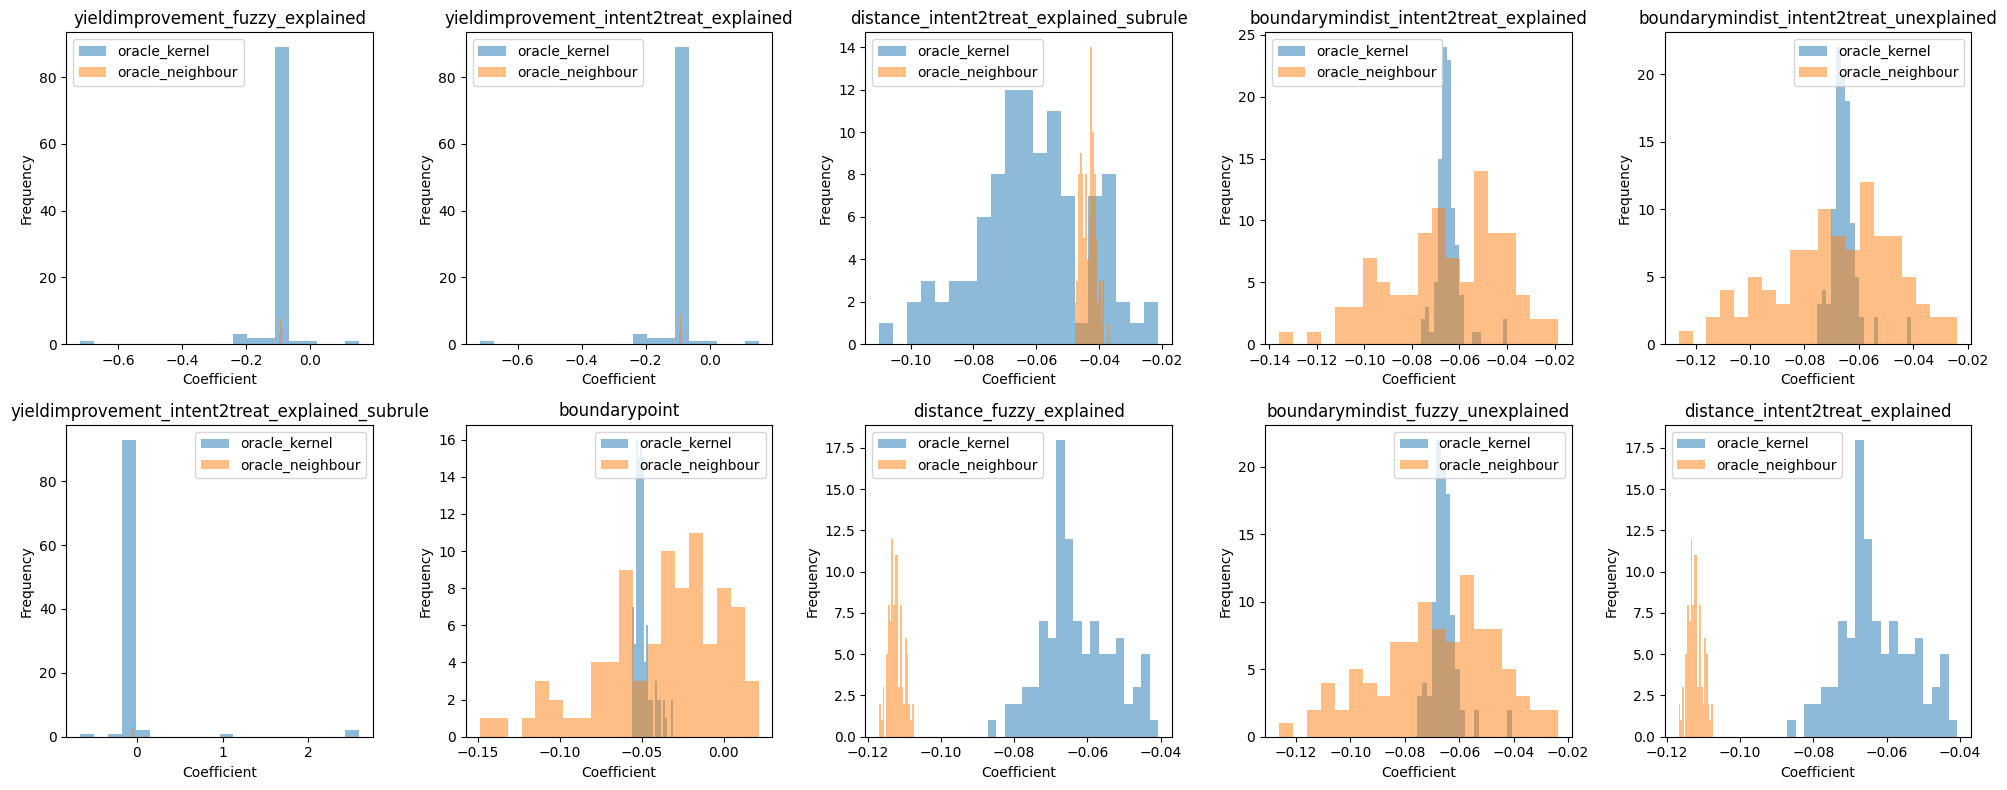

In [87]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for ax, setting in zip(axes, unique_settings):
    setting_df = df_res[df_res['setting'] == setting]
    
    oracle_kernel_df = setting_df[setting_df['method'] == 'oracle_kernel']
    oracle_neighbour_df = setting_df[setting_df['method'] == 'oracle_neighbour']
    
    ax.hist(oracle_kernel_df['coef_conventional'], bins=20, alpha=0.5, label='oracle_kernel')
    ax.hist(oracle_neighbour_df['coef_conventional'], bins=20, alpha=0.5, label='oracle_neighbour')
    
    ax.set_title(f"{setting}")
    ax.set_xlabel("Coefficient")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()

## Standard Errors

In [73]:
descriptive_stats["mean robust coef"] = 0
descriptive_stats["mean robust se"] = 0
for index in descriptive_stats.index:
    mean = df_res.loc[(df_res.method=="rdrobust") & (df_res.setting == index[0]), "coef_robust"].mean()
    se = df_res.loc[(df_res.method=="rdrobust") & (df_res.setting == index[0]), "se_robust"].mean()
    descriptive_stats.loc[index, "mean robust coef"] = mean
    descriptive_stats.loc[index, "mean robust se"] = se

C:\Users\BAQ7040\AppData\Local\Temp\ipykernel_26252\3802664893.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.06378504476459311' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  descriptive_stats.loc[index, "mean robust coef"] = mean
C:\Users\BAQ7040\AppData\Local\Temp\ipykernel_26252\3802664893.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.019834117089961613' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  descriptive_stats.loc[index, "mean robust se"] = se


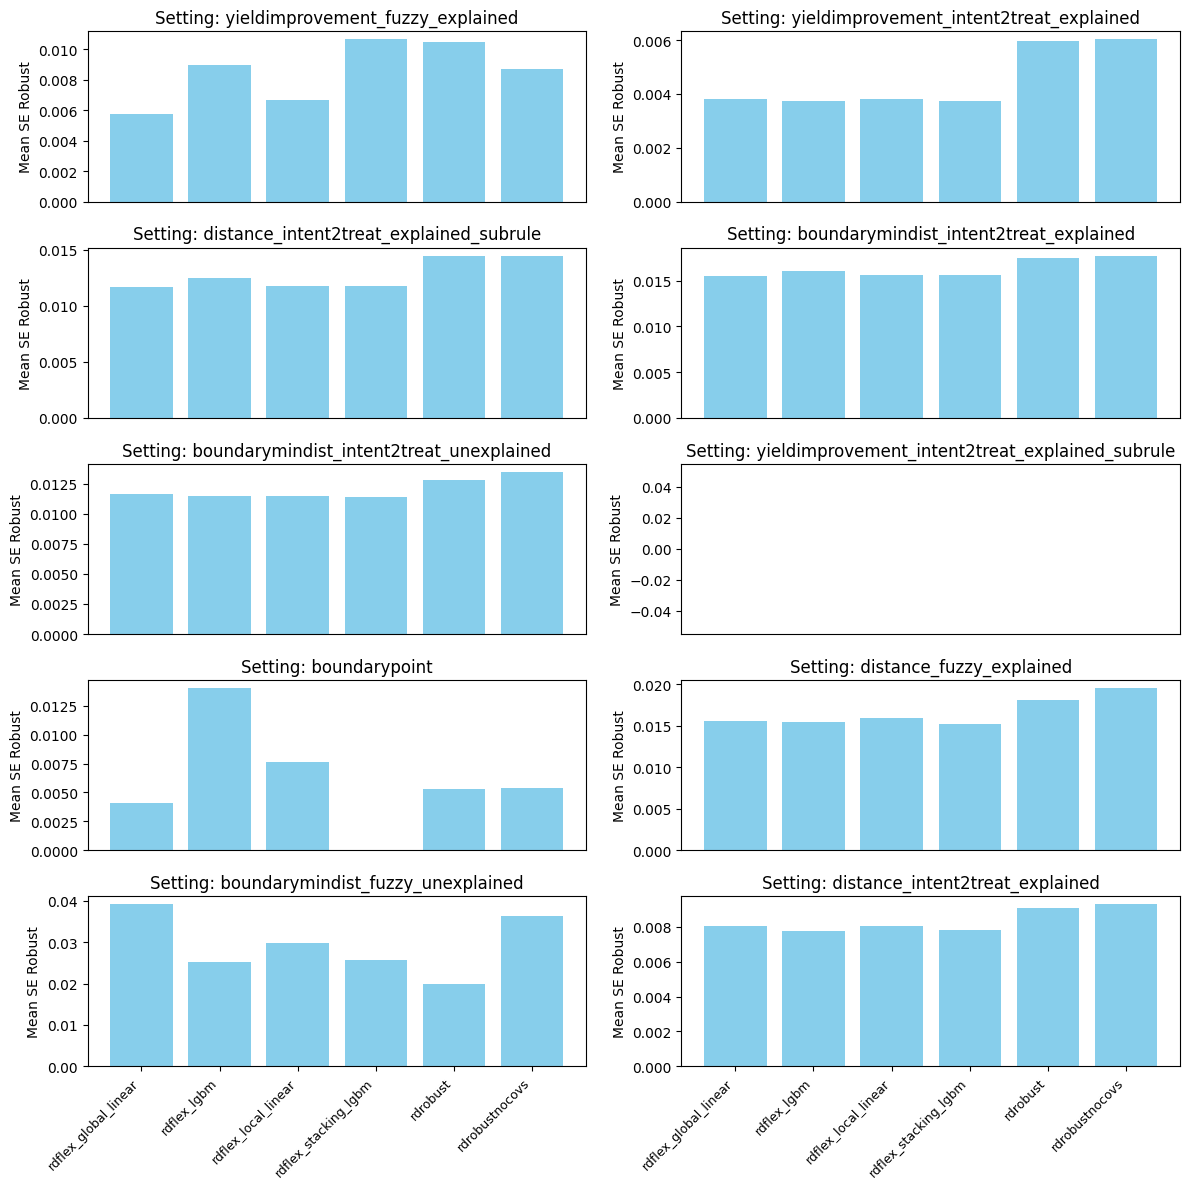

In [33]:
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, s in zip(axes, unique_settings):
    sdf = grouped.get_group(s)
    
    sdf_mean_se = sdf.groupby('method')['se_robust'].mean().reset_index()
    sdf_mean_se = sdf_mean_se[sdf_mean_se['method'].isin(methods)]
    
    ax.bar(sdf_mean_se['method'], sdf_mean_se['se_robust'], color='skyblue')
    
    ax.set_title(f"Setting: {s}")
    ax.set_ylabel("Mean SE Robust")
    
    row_index = list(unique_settings).index(s) // 2
    if row_index == 4: 
        ax.set_xticks(range(len(sdf_mean_se['method'])))
        ax.set_xticklabels(sdf_mean_se['method'], rotation=45, ha='right', fontsize=9)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

plt.tight_layout()
plt.show()

## Confidence Intervals

In [79]:
def is_within_ci(row, oracle_value):
    return int(row['ci_0025_robust'] <= oracle_value <= row['ci_0975_robust'])

df_res['within_ci_oracle_kernel'] = 0
df_res['within_ci_oracle_neighbour'] = 0
df_res["mean_oracle_kernel_within_ci"] = False
df_res["mean_oracle_neighbour_within_ci"] = False

for setting in unique_settings:
    setting_df = df_res[df_res['setting'] == setting]
    
    for rep in setting_df['rep'].unique():
        rep_df = setting_df[setting_df['rep'] == rep]
        
        oracle_kernel_value = rep_df.loc[rep_df['method'] == 'oracle_kernel', 'coef_conventional'].values[0]
        df_res.loc[
            (df_res['setting'] == setting) & (df_res['rep'] == rep),
            'within_ci_oracle_kernel'
        ] = rep_df.apply(is_within_ci, oracle_value=oracle_kernel_value, axis=1)
        
        oracle_neighbour_value = rep_df.loc[rep_df['method'] == 'oracle_neighbour', 'coef_conventional'].values[0]
        oracle_neighbour_value = oracle_neighbour_value
        df_res.loc[
            (df_res['setting'] == setting) & (df_res['rep'] == rep),
            'within_ci_oracle_neighbour'
        ] = rep_df.apply(is_within_ci, oracle_value=oracle_neighbour_value, axis=1)
    
    mean_kernel_oracle = setting_df.loc[setting_df.method == "oracle_kernel", "coef_conventional"].mean()
    mean_neighbour_oracle = setting_df.loc[setting_df.method == "oracle_neighbour", "coef_conventional"].mean()
    df_res.loc[df_res.setting == setting, "mean_oracle_kernel_within_ci"] = (df_res.loc[df_res.setting == setting, 'ci_0025_robust'] <= mean_kernel_oracle) & (mean_kernel_oracle <= df_res.loc[df_res.setting == setting, 'ci_0975_robust'])
    df_res.loc[df_res.setting == setting, "mean_oracle_neighbour_within_ci"] = (df_res.loc[df_res.setting == setting, 'ci_0025_robust'] <= mean_neighbour_oracle) & (mean_neighbour_oracle <= df_res.loc[df_res.setting == setting, 'ci_0975_robust'])

df_res.loc[df_res.method.isin(methods)].groupby(["setting", "method"])[["within_ci_oracle_kernel", "within_ci_oracle_neighbour", "mean_oracle_kernel_within_ci", "mean_oracle_neighbour_within_ci"]].mean()

within_ci_oracle_kernel  \
setting                                         method                                          
boundarymindist_fuzzy_unexplained               rdflex_global_linear                     0.96   
                                                rdflex_lgbm                              0.95   
                                                rdflex_local_linear                      0.96   
                                                rdflex_stacking_lgbm                     0.93   
                                                rdrobust                                 0.93   
                                                rdrobustnocovs                           0.85   
boundarymindist_intent2treat_explained          rdflex_global_linear                     0.92   
                                                rdflex_lgbm                              0.91   
                                                rdflex_local_linear                      0.92   
                                                rdflex_stacking_lgbm                     0.92   
                                                rdrobust                                 0.91   
                                                rdrobustnocovs                           0.92   
boundarymindist_intent2treat_unexplained        rdflex_global_linear                     0.40   
                                                rdflex_lgbm                              0.37   
                                                rdflex_local_linear                      0.40   
                                                rdflex_stacking_lgbm                     0.37   
                                                rdrobust                                 0.40   
                                                rdrobustnocovs                           0.41   
boundarypoint                                   rdflex_global_linear                     0.01   
                                                rdflex_lgbm                              0.01   
                                                rdflex_local_linear                      0.01   
                                                rdflex_stacking_lgbm                     0.00   
                                                rdrobust                                 0.00   
                                                rdrobustnocovs                           0.00   
distance_fuzzy_explained                        rdflex_global_linear                     0.97   
                                                rdflex_lgbm                              1.00   
                                                rdflex_local_linear                      0.98   
                                                rdflex_stacking_lgbm                     0.97   
                                                rdrobust                                 0.97   
                                                rdrobustnocovs                           0.96   
distance_intent2treat_explained                 rdflex_global_linear                     0.00   
                                                rdflex_lgbm                              0.01   
                                                rdflex_local_linear                      0.00   
                                                rdflex_stacking_lgbm                     0.00   
                                                rdrobust                                 0.00   
                                                rdrobustnocovs                           0.00   
distance_intent2treat_explained_subrule         rdflex_global_linear                     0.99   
                                                rdflex_lgbm                              0.93   
                                                rdflex_local_linear                      0.99   
                                                rdflex_stacking_lgbm                     0.98

## Errors

In [81]:
error_counts = df_res[df_res['method'].isin(methods)].groupby(['setting', 'method'])['error'].apply(lambda x: x.notna().sum()).reset_index()
error_counts.columns = ['setting', 'method', 'error_count']
error_counts

,setting,method,error_count
0,boundarymindist_fuzzy_unexplained,rdflex_global_linear,0
1,boundarymindist_fuzzy_unexplained,rdflex_lgbm,0
2,boundarymindist_fuzzy_unexplained,rdflex_local_linear,0
3,boundarymindist_fuzzy_unexplained,rdflex_stacking_lgbm,0
4,boundarymindist_fuzzy_unexplained,rdrobust,0
5,boundarymindist_fuzzy_unexplained,rdrobustnocovs,0
6,boundarymindist_intent2treat_explained,rdflex_global_linear,0
7,boundarymindist_intent2treat_explained,rdflex_lgbm,0
8,boundarymindist_intent2treat_explained,rdflex_local_linear,0
9,boundarymindist_intent2treat_explained,rdflex_stacking_lgbm,0
